# EfficientNetB3 - Transfer Learning Model - EDP

### Author -  Charvi Jain and Shaurya Singh Srinet

### Installing required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import cv2
import os
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings('ignore')
import visualkeras
from pathlib import Path
import PIL
import os
from tqdm import tqdm

### Defining batch size and generating training dataset

In [36]:
#reding input data from local machine as base directory
base_directory = r"C:\Users\Charvi Jain\Downloads\dataset"

image_size = (224, 224)
batch_size = 64

train_data = tf.keras.utils.image_dataset_from_directory(
    directory=base_directory,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=2022
)


Found 4217 files belonging to 4 classes.


### Data Distribution

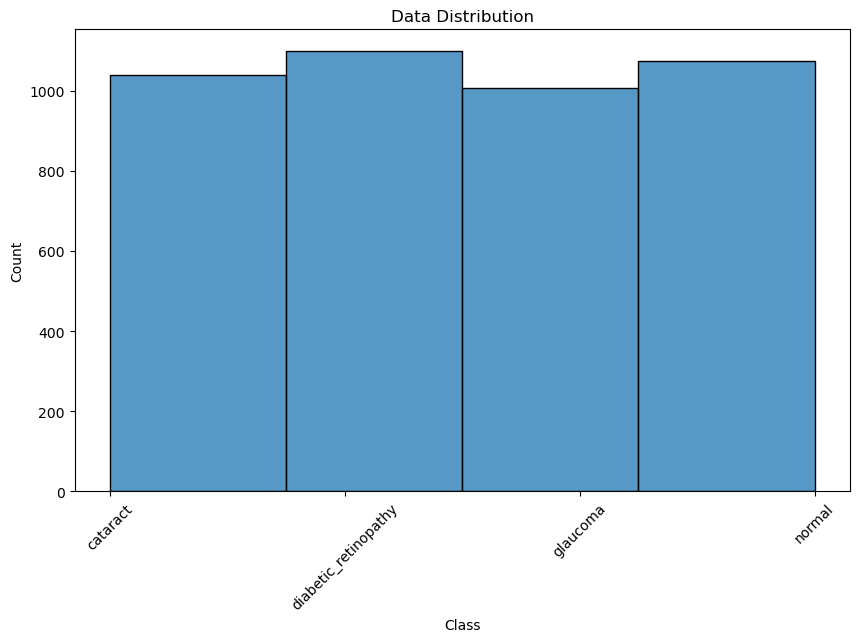

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating class counts manually
class_counts = []
for data_batch, label_batch in train_data:
    class_counts.extend(label_batch.numpy())

# Get class names
class_names = train_data.class_names

# Plotting the data distribution
plt.figure(figsize=(10, 6))
sns.histplot(class_counts, bins=len(class_names), kde=False)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Distribution')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.show()


In [41]:
df = pd.concat(dfs, ignore_index=True)
df

,image,disease_type
0,C:\Users\Charvi Jain\Downloads\dataset\glaucom...,0
1,C:\Users\Charvi Jain\Downloads\dataset\glaucom...,0
2,C:\Users\Charvi Jain\Downloads\dataset\glaucom...,0
3,C:\Users\Charvi Jain\Downloads\dataset\glaucom...,0
4,C:\Users\Charvi Jain\Downloads\dataset\glaucom...,0
...,...,...
4212,C:\Users\Charvi Jain\Downloads\dataset\diabeti...,3
4213,C:\Users\Charvi Jain\Downloads\dataset\diabeti...,3
4214,C:\Users\Charvi Jain\Downloads\dataset\diabeti...,3
4215,C:\Users\Charvi Jain\Downloads\dataset\diabeti...,3


###  Shuffle the data to avoid bias


In [42]:
from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

# Assuming you have labels in df['disease_type']
num_classes = 4

### Label Mapping

In [43]:
class_names = ["glaucoma", "cataract", "normal", "diabetic_retinopathy"]
for idx, name in enumerate(class_names):
    print(f"{idx} = {name}", end=", ")

0 = glaucoma, 1 = cataract, 2 = normal, 3 = diabetic_retinopathy, 

### Pie Chart Distribution of Data

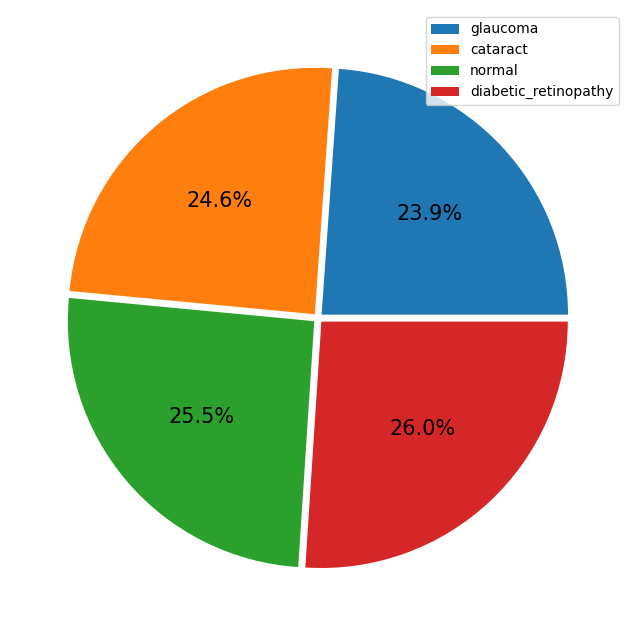

In [44]:
# Define the class distribution
values = df['disease_type'].value_counts().sort_index()

# Display a pie chart of data distribution
plt.figure(figsize=(12, 8))
plt.pie(values, autopct='%1.1f%%', explode=[0.02, 0.02, 0.02, 0.02], textprops={"fontsize": 15})
plt.legend(labels=class_names)
plt.show()


### Preprocessing the images

Found 4217 images belonging to 4 classes.


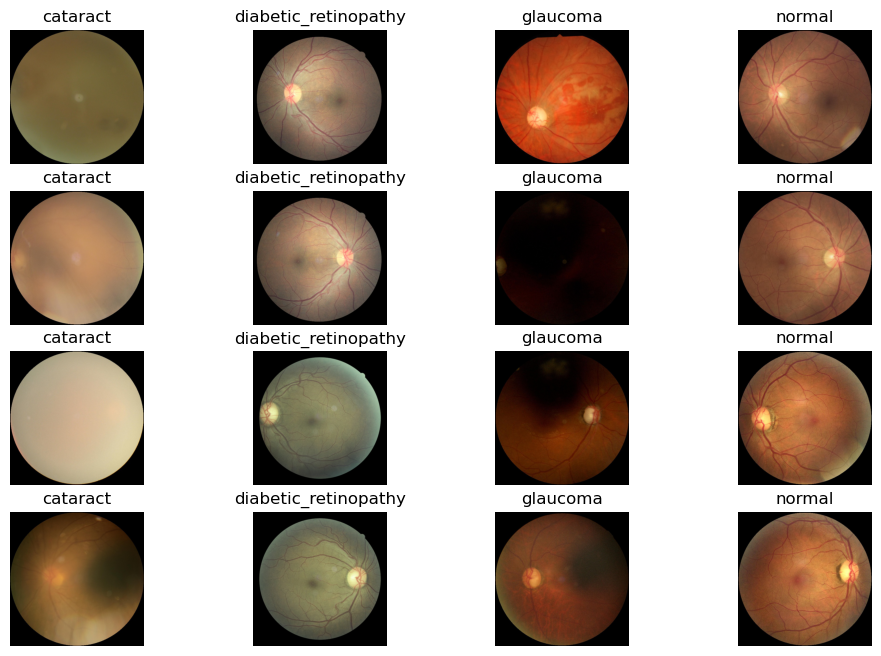

In [48]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)

# Create a data generator for your dataset
batch_size = 32  # Set the batch size as needed
train_generator = datagen.flow_from_directory(
    base_directory,
    target_size=(224, 224),  # target image size
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    shuffle=False  # Ensure data isn't shuffled
)

# Explore the data by displaying a limited number of images for each class
class_names = list(train_generator.class_indices.keys())
num_images_per_class = 4

# Create a dictionary to keep track of displayed images
displayed_images = {class_name: 0 for class_name in class_names}

# Display a limited number of images for each class
plt.figure(figsize=(12, 8))
for i in range(len(train_generator.filenames)):
    image_path = os.path.join(base_directory, train_generator.filenames[i])
    class_name = class_names[train_generator.labels[i]]

    if displayed_images[class_name] < num_images_per_class:
        img = plt.imread(image_path)
        plt.subplot(num_images_per_class, len(class_names), displayed_images[class_name] * len(class_names) + class_names.index(class_name) + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
        displayed_images[class_name] += 1

    # Stop when all images have been displayed
    if all(count >= num_images_per_class for count in displayed_images.values()):
        break

plt.show()

### Splitting the train, test dataset size

In [53]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Check the size of the training and testing sets
print("Training set size:", len(train_df))
print("Testing set size:", len(test_df))


Training set size: 3373
Testing set size: 844


### Creating 3 dataset batches -  
#### 1. Training Batch 2. Testing Batch 3. Validation Batch

In [56]:
# Calculate the total number of batches
total_batches = len(train_data)
print("total batches = ",total_batches)
# Define the sizes for train, validate, and test
train_size = int(0.7 * total_batches) + 1
val_size = int(0.2 * total_batches)
test_size = int(0.1 * total_batches)

# Create the train dataset
train = train_data.take(train_size)

# Create the remaining dataset
remaining = train_data.skip(train_size)

# Create the validate dataset
val = remaining.take(val_size)

# Create the test dataset
test = remaining.skip(val_size)

# Calculate the number of batches in each dataset
num_train_batches = len(train)
num_val_batches = len(val)
num_test_batches = len(test)

print(f"# train batches = {num_train_batches}, # validate batches = {num_val_batches}, # test batches = {num_test_batches}")


total batches =  66
# train batches = 47, # validate batches = 13, # test batches = 6


In [58]:
test_iter = test.as_numpy_iterator()
test_set = {"images": np.empty((0, 224, 224, 3)), "labels": np.empty(0)}
while True:
    try:
        batch = test_iter.next()
        test_set['images'] = np.concatenate((test_set['images'], batch[0]))
        test_set['labels'] = np.concatenate((test_set['labels'], batch[1]))
    except:
        break

y_true = test_set['labels']


### Creating EfficientNetB3 Model

In [59]:
def make_model():
    effnet = EfficientNetB3(include_top=False, weights="imagenet",input_shape=(224,224,3), pooling='max') 
    effnet.trainable=False
    
    for layer in effnet.layers[83:]:
      layer.trainable=True
    
    x = effnet.output
    x = BatchNormalization()(x)
    x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x = Dropout(rate=.45, seed=2022)(x)        
    output=Dense(4, activation='softmax')(x)
    
    model= tf.keras.Model(inputs=effnet.input, outputs=output)
    model.compile(optimizer = 'adamax', loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
    return model

In [60]:
model = make_model()

### Train the Model


In [61]:
from keras import callbacks 
early_stop = callbacks.EarlyStopping(
        monitor="val_accuracy", 
        patience=10,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )

history = model.fit(
    train,
    validation_data=val,
    epochs = 50,
    callbacks=[early_stop],
)

Epoch 1/50
47/47 [==============================] - 378s 8s/step - loss: 17.2780 - accuracy: 0.7919 - val_loss: 13.1197 - val_accuracy: 0.7668
Epoch 2/50
47/47 [==============================] - 360s 8s/step - loss: 10.0295 - accuracy: 0.9166 - val_loss: 8.0126 - val_accuracy: 0.9002
Epoch 3/50
47/47 [==============================] - 356s 8s/step - loss: 6.3884 - accuracy: 0.9402 - val_loss: 5.2126 - val_accuracy: 0.9111
Epoch 4/50
47/47 [==============================] - 353s 7s/step - loss: 4.2011 - accuracy: 0.9621 - val_loss: 3.5384 - val_accuracy: 0.9111
Epoch 5/50
47/47 [==============================] - 350s 7s/step - loss: 2.8173 - accuracy: 0.9688 - val_loss: 2.3971 - val_accuracy: 0.9279
Epoch 6/50
47/47 [==============================] - 352s 7s/step - loss: 1.9249 - accuracy: 0.9834 - val_loss: 1.7084 - val_accuracy: 0.9291
Epoch 7/50
47/47 [==============================] - 354s 8s/step - loss: 1.3502 - accuracy: 0.9820 - val_loss: 1.2245 - val_accuracy: 0.9459
Epoch 8/50

### Visualizing Model Accuracy and Model Loss 

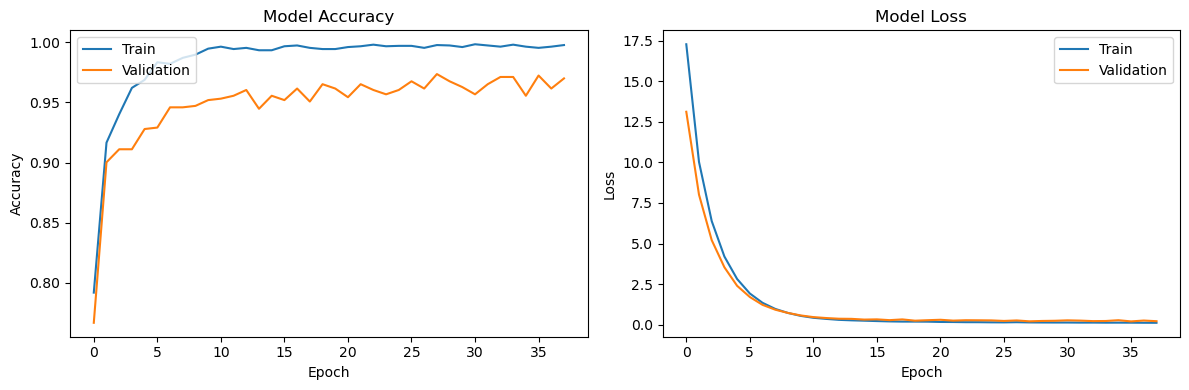

In [68]:
import matplotlib.pyplot as plt

def plot_his(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))  # Set the figure size for both plots

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

# Call this function with your training history to plot accuracy and loss
plot_his(history)


### Evaluating the model on test set

In [64]:
y_pred = np.argmax(model.predict(test_set['images']), 1)

12/12 [==============================] - 15s 1s/step


### Classification Report

In [65]:
print(classification_report(y_true, y_pred, target_names = class_names))

                      precision    recall  f1-score   support

            cataract       0.97      0.98      0.97        92
diabetic_retinopathy       1.00      0.99      0.99        96
            glaucoma       0.93      0.91      0.92        92
              normal       0.93      0.95      0.94        97

            accuracy                           0.96       377
           macro avg       0.96      0.96      0.96       377
        weighted avg       0.96      0.96      0.96       377



### Generating Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

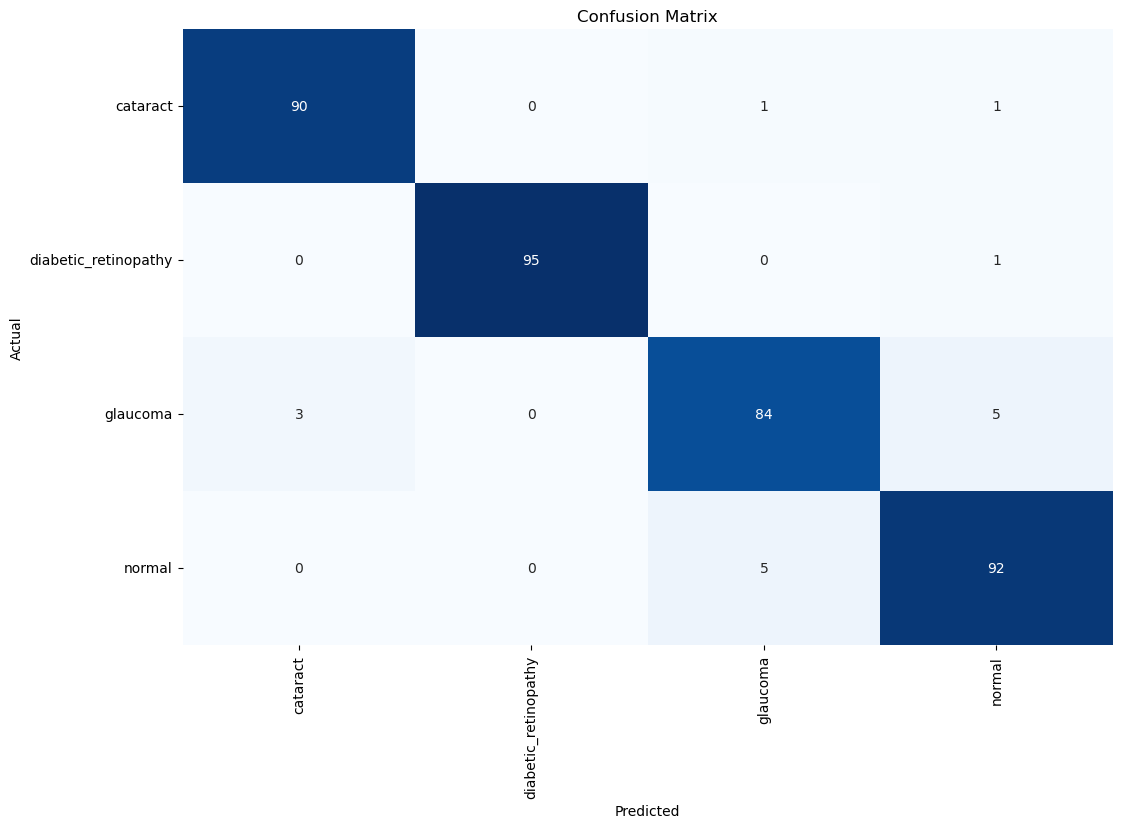

In [66]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(4)+.5, class_names, rotation=90)
plt.yticks(np.arange(4)+.5, class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

### Saving the model

In [67]:
model.save("EfficientNet.h5")